In [29]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [30]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tf2onnx
import onnx
import yfinance as yfin
import time


In [3]:
# s3_client = boto3.client('s3')
# response = s3_client.get_object(Bucket="gmidha-bigdata-nov07", Key="msftdata.csv")

# status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

# if status == 200:
#     print(f"Successful S3 get_object response. Status - {status}")
#     msft_df = pd.read_csv(response.get("Body"))
#     print(msft_df)
# else:
#     print(f"Unsuccessful S3 get_object response. Status - {status}")

In [4]:
# conn = trino.dbapi.connect(
#         host,
#         port,
#         http_scheme='http',
#         user='admin'
#         )

In [5]:
#msft = pd.read_csv("../msftdata.csv")

In [64]:

yfin.pdr_override()

msft = pdr.get_data_yahoo('TSLA', start='2017-01-01', end='2022-02-01')

print(msft)

/opt/app-root/lib64/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-03   14.324000   14.688667   14.064000   14.466000   14.466000   
2017-01-04   14.316667   15.200000   14.287333   15.132667   15.132667   
2017-01-05   15.094667   15.165333   14.796667   15.116667   15.116667   
2017-01-06   15.128667   15.354000   15.030000   15.267333   15.267333   
2017-01-09   15.264667   15.461333   15.200000   15.418667   15.418667   
...                ...         ...         ...         ...         ...   
2022-01-25  304.733337  317.086670  301.070007  306.133331  306.133331   
2022-01-26  317.476654  329.230011  302.000000  312.470001  312.470001   
2022-01-27  311.119995  311.796661  276.333344  276.366669  276.366669   
2022-01-28  277.186676  285.833344  264.003326  282.116669  282.116669   
2022-01-31  290.903320  312.663330  287.350006  312.239990  312.239990   

               Volume  
Date         

In [65]:

msft.shape

(1279, 6)

In [66]:
msft = msft.reset_index()

In [67]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500
1,2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500
2,2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500
3,2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500
4,2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500


In [68]:
msft.index = pd.to_datetime(msft['Date'], format='%d.%m.%Y %H:%M:%S')

print(msft)

                 Date        Open        High         Low       Close  \
Date                                                                    
2017-01-03 2017-01-03   14.324000   14.688667   14.064000   14.466000   
2017-01-04 2017-01-04   14.316667   15.200000   14.287333   15.132667   
2017-01-05 2017-01-05   15.094667   15.165333   14.796667   15.116667   
2017-01-06 2017-01-06   15.128667   15.354000   15.030000   15.267333   
2017-01-09 2017-01-09   15.264667   15.461333   15.200000   15.418667   
...               ...         ...         ...         ...         ...   
2022-01-25 2022-01-25  304.733337  317.086670  301.070007  306.133331   
2022-01-26 2022-01-26  317.476654  329.230011  302.000000  312.470001   
2022-01-27 2022-01-27  311.119995  311.796661  276.333344  276.366669   
2022-01-28 2022-01-28  277.186676  285.833344  264.003326  282.116669   
2022-01-31 2022-01-31  290.903320  312.663330  287.350006  312.239990   

             Adj Close     Volume  
Date          

In [69]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1279 entries, 2017-01-03 to 2022-01-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1279 non-null   datetime64[ns]
 1   Open       1279 non-null   float64       
 2   High       1279 non-null   float64       
 3   Low        1279 non-null   float64       
 4   Close      1279 non-null   float64       
 5   Adj Close  1279 non-null   float64       
 6   Volume     1279 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 79.9 KB


<Axes: xlabel='Date'>

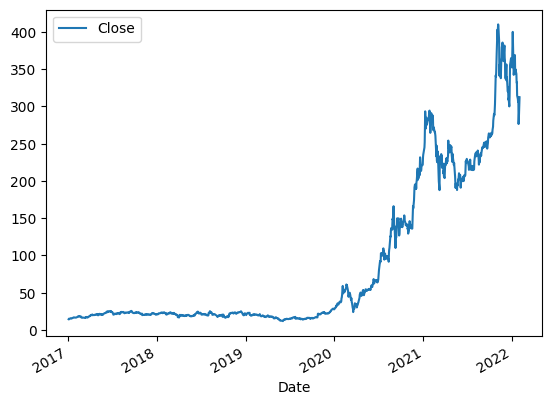

In [70]:
close_data = msft.filter(['Close'])
close_data.plot()

In [71]:
dataset = close_data.values
print(dataset)
training = int(np.ceil(len(dataset) * .7))
print(training)

[[ 14.4659996 ]
 [ 15.13266659]
 [ 15.11666679]
 ...
 [276.3666687 ]
 [282.1166687 ]
 [312.23999023]]
896


In [72]:

 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:int(training), :]
print(train_data)
# prepare feature and labels
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[[0.00636789]
 [0.00804277]
 [0.00800257]
 [0.0083811 ]
 [0.0087613 ]
 [0.00852514]
 [0.00850169]
 [0.00847824]
 [0.00984494]
 [0.00948149]
 [0.00994711]
 [0.01085155]
 [0.011014  ]
 [0.01171578]
 [0.01266879]
 [0.01264534]
 [0.01231706]
 [0.01239076]
 [0.01200219]
 [0.01221992]
 [0.01176938]
 [0.01215628]
 [0.01211943]
 [0.01319805]
 [0.01314948]
 [0.01391992]
 [0.01511244]
 [0.01511746]
 [0.0170218 ]
 [0.01708544]
 [0.01688111]
 [0.01507057]
 [0.01561992]
 [0.01648416]
 [0.01583431]
 [0.01289992]
 [0.01306908]
 [0.01126524]
 [0.01189499]
 [0.01190002]
 [0.01197706]
 [0.01215963]
 [0.01209933]
 [0.01166051]
 [0.01137243]
 [0.01104248]
 [0.01083982]
 [0.01125519]
 [0.01323657]
 [0.01285638]
 [0.0139149 ]
 [0.01382278]
 [0.01389312]
 [0.01201056]
 [0.01273579]
 [0.01269726]
 [0.01410081]
 [0.01528328]
 [0.01649421]
 [0.01648249]
 [0.01657293]
 [0.01663658]
 [0.02002318]
 [0.02089077]
 [0.01943363]
 [0.02005333]
 [0.02069648]
 [0.02234624]
 [0.02172989]
 [0.0197418 ]
 [0.02094102]
 [0.02

In [73]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary



<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7f06d6c01a90>>

In [74]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
27/27 [==============================] - 3s 28ms/step - loss: 7.3994e-04
Epoch 2/10
27/27 [==============================] - 1s 27ms/step - loss: 2.4704e-04
Epoch 3/10
27/27 [==============================] - 1s 27ms/step - loss: 1.5997e-04
Epoch 4/10
27/27 [==============================] - 1s 27ms/step - loss: 1.7221e-04
Epoch 5/10
27/27 [==============================] - 1s 26ms/step - loss: 1.4991e-04
Epoch 6/10
27/27 [==============================] - 1s 26ms/step - loss: 1.1535e-04
Epoch 7/10
27/27 [==============================] - 1s 26ms/step - loss: 1.2901e-04
Epoch 8/10
27/27 [==============================] - 1s 26ms/step - loss: 2.0433e-04
Epoch 9/10
27/27 [==============================] - 1s 27ms/step - loss: 1.2612e-04
Epoch 10/10
27/27 [==============================] - 1s 26ms/step - loss: 1.6051e-04


In [75]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_test)

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

actual = scaler.inverse_transform(test_data)
print(actual)

print("===")
print(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


[[[0.10098014]
  [0.08748731]
  [0.09751481]
  ...
  [0.23672072]
  [0.22344562]
  [0.20735507]]

 [[0.08748731]
  [0.09751481]
  [0.09869058]
  ...
  [0.22344562]
  [0.20735507]
  [0.22788908]]

 [[0.09751481]
  [0.09869058]
  [0.10109738]
  ...
  [0.20735507]
  [0.22788908]
  [0.21731893]]

 ...

 [[0.98214581]
  [0.95150385]
  [0.98655908]
  ...
  [0.74884349]
  [0.73912919]
  [0.75504892]]

 [[0.95150385]
  [0.98655908]
  [1.        ]
  ...
  [0.73912919]
  [0.75504892]
  [0.66434585]]

 [[0.98655908]
  [1.        ]
  [0.99345124]
  ...
  [0.75504892]
  [0.66434585]
  [0.67879168]]]
12/12 [==============================] - 0s 8ms/step
[[ 52.12533188]
 [ 46.75466537]
 [ 50.74599838]
 [ 51.2140007 ]
 [ 52.17200089]
 [ 52.00266647]
 [ 54.62799835]
 [ 54.08599854]
 [ 53.96066666]
 [ 52.73066711]
 [ 53.55533218]
 [ 53.27799988]
 [ 54.24200058]
 [ 53.86733246]
 [ 54.3706665 ]
 [ 55.17333221]
 [ 54.45866776]
 [ 54.59133148]
 [ 54.68199921]
 [ 53.72066879]
 [ 55.66666794]
 [ 59.87333298]
 

/tmp/ipykernel_510/3634165671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


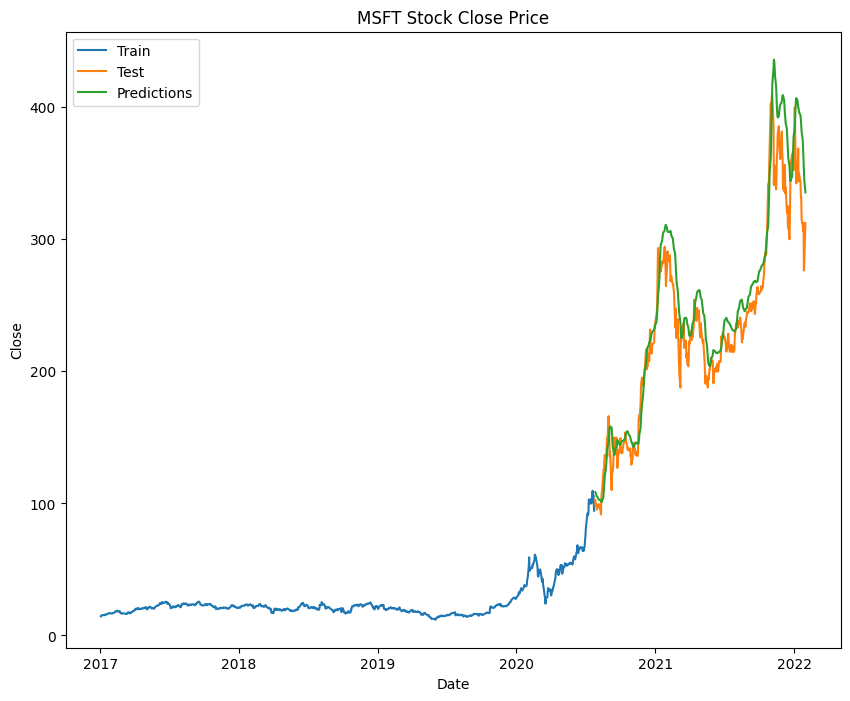

In [76]:
train = msft[:training]
test = msft[training:]
test['Predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('MSFT Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

In [77]:
model.save("./stock_predict.keras")

In [78]:
onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx.save(onnx_model, "./model.onnx")

2024-02-13 14:40:22.073116: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-13 14:40:22.073226: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-13 14:40:22.173727: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-13 14:40:22.173822: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
